# Encontrando o melhor número de componentes principais para utilizar na redução de dimensionalidade do SESA Dataset

Esse jupyter tem como objetivo determinar qual é o melhor número de componentes principais para ser utilizado na redução de dimensionalidade do dataset SESA. Esse valor será amplamente utilizado na classe que extrai features, pois essa classe também é responsável por escalonar e reduzir a dimensão dos dados. Toda a implementação dessa classe está descrita no jupyter "Implementação de classe para extração de features - SESA Dataset".

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import Isomap, TSNE

import sys
sys.path.append('/home/dimi/Programming/IC2019/ML/python')
from treinarEClassificarClass import TreinarEClassificar

In [2]:
#DEFININDO ALGUNS PARÂMETROS PARA PLOTAR GRÁFICOS
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
params = {'figure.figsize': [7, 4], 
          'axes.labelsize': 12,
          'axes.titlesize':16, 
          'font.size': 12,
          'legend.fontsize': 12, 
          'xtick.labelsize': 10, 
          'ytick.labelsize': 10
         }

plt.rcParams.update(params)

## Utilizando o método da análise de variância

De acordo com https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe, é possível fazer uma análise do PCA olhando para a variância em função do número de componentes principais.

Até o momento, possuímos um CSV com mais de 100 features. Esse CSV diz respeito aos dados da pasta de TREINO do SESA. Ele será utilizado para fazer a análise do PCA. Ou seja, o número de componentes principais que será escolhido terá base apenas nos dados de treinamento. Posteriormente, todos os dados serão reduzidos à essa nova dimensionalidade, até mesmo os de teste.

In [ ]:
# ABRINDO O CSV COM NUMPY
caminhoCSV = '/home/dimi/Programming/IC2019/ML/datasets/SESA/SESA_Normalizado/train/treino_normalizado_semPCA.csv'
data = np.genfromtxt(caminhoCSV, delimiter=',')

# EXCLUINDO A PRIMEIRA COLUNA (ARQUIVO) E A ULTIMA (CLASSE)
data = data[:,1:-1]

In [ ]:
objPCA = PCA().fit(data)

In [ ]:
plt.figure()
plt.plot(np.cumsum(objPCA.explained_variance_ratio_))
plt.xlabel('Número de componentes principais')
plt.ylabel('Variância (%)')
plt.title('Análise do PCA')
plt.xlim(0,109)
plt.grid()
plt.show()

### Encontrando o número de features que garante 95% de variância

In [ ]:
plt.figure()
plt.plot(np.cumsum(objPCA.explained_variance_ratio_))
plt.xlabel('Número de componentes principais')
plt.ylabel('Variância (%)')
plt.title('Análise do PCA - ZOOM')
plt.ylim(0.90, 1)
plt.xlim(50,60)
plt.grid()
plt.show()

## Utilizando um método iterativo

Aqui, vou pegar o dataset original de treino e teste (já normalizados pela energia)e vou reduzi-los gradativamente para plotar uma curva de acurácia em função da dimensionalidade.

#### Definindo função para reduzir a dimensionalidade

In [48]:
def reduzirDimensionalidade(dataframeGeral, algoritmo, nDimensoes):
    
    print("Reduzindo a dimensionalidade para", nDimensoes)
    
    # COPIANDO AS COLUNAS DE NOME E CLASSIFICACAO
    colunaArquivo       = dataframeGeral["nomeArquivo"]
    colunaClassificacao = dataframeGeral["classificacaoCorreta"]
    
    # DELETANDO AS COLUNAS ARQUIVO E CLASSIFICACAO
    dataframeGeral = dataframeGeral.drop(['nomeArquivo', 'classificacaoCorreta'], axis=1)
    
    # REDUZINDO A DIMENSIONALIDADE
    if algoritmo == "PCA":
        dataframeGeral = pd.DataFrame(PCA(n_components=nDimensoes).fit_transform(dataframeGeral.to_numpy()))
    elif algoritmo == "FastICA":
        dataframeGeral = pd.DataFrame(FastICA(n_components=nDimensoes).fit_transform(dataframeGeral.to_numpy()))
    elif algoritmo == "TSNE":
        dataframeGeral = pd.DataFrame(TSNE(n_components=nDimensoes).fit_transform(dataframeGeral.to_numpy()))
    else:
        dataframeGeral = pd.DataFrame(Isomap(n_components=nDimensoes).fit_transform(dataframeGeral.to_numpy()))   
    
    # COM ESSA COISA DE TIRA E POE COLUNA, O PANDAS NAO SABE LINDAR COM OS INDEXES,
    # ABAIXO EU ESTOU RESETANDO TUDO
    colunaArquivo.reset_index(inplace=True, drop=True)
    colunaClassificacao.reset_index(inplace=True, drop=True)
    dataframeGeral.reset_index(inplace=True, drop=True)
    
    # ADICIONANDO AS COLUNAS QUE FORAM EXCLUIDAS (posicaoNovaColuna, nomeNovaColuna, valorParaTodasAsLinhas)
    dataframeGeral.insert(0, "nomeArquivo", colunaArquivo, True)
    dataframeGeral.insert(len(dataframeGeral.columns), "classificacaoCorreta", colunaClassificacao, True)
    
    return dataframeGeral

#### Rodando o algoritmo

In [53]:
# ABRINDO OS CSVS DE TREINO E TESTE
caminhoCSVTreino        = '/home/dimi/Programming/IC2019/ML/datasets/SESA/SESA_Normalizado/train/treino_normalizado_semPCA.csv'
caminhoCSVTeste         = '/home/dimi/Programming/IC2019/ML/datasets/SESA/SESA_Normalizado/test/teste_normalizado_semPCA.csv'
dataframeTreinoOriginal = pd.read_csv(caminhoCSVTreino)
dataframeTesteOriginal  = pd.read_csv(caminhoCSVTeste)

# DEFININDO QUAIS SERAO OS CLASSIFICADORES UTILIZADOS
arrayStringsClassificadores = ["KNeighborsClassifier()"]

# ARRAY QUE VAI GUARDAR A ACURACIA MEDIA DO CLASSIFICADOR PARA CADA N DE DIMENSOES
arrayAcuraciaMedia = []

# PARA CADA QTD DE DIMENSOES
for dimensionalidadeAtual in range(len(dataframeTreinoOriginal.columns) - 2, 19, -1):
    
    print("Testando com", dimensionalidadeAtual, "dimensões")
    
    # EU FACO A REDUCAO DOS DATASETS DE TREINO E TESTE
    algoritmo = "PCA"
    dataframeTreinoReduzido = reduzirDimensionalidade(dataframeTreinoOriginal, algoritmo, dimensionalidadeAtual)
    dataframeTesteReduzido  = reduzirDimensionalidade(dataframeTesteOriginal, algoritmo, dimensionalidadeAtual)
    
    # dataframeTreinoReduzido = dataframeTreinoOriginal
    # dataframeTesteReduzido  = dataframeTesteOriginal
    
    # CRIO UM OBJETO DA PASTA DE TREINAMENTO E TESTE DE CLASSIFICADORES 
    objTreinarEClassificar = TreinarEClassificar()
    
    # TREINO
    arrayObjClassificadores = objTreinarEClassificar.criarETreinarClassificadores(dataframeTreinoReduzido, arrayStringsClassificadores, kCrossValidation=3, verbose=False)
    
    # TESTO
    objTreinarEClassificar.classificarDataframe(dataframeTesteReduzido, arrayObjClassificadores, verbose=False)
    
    # GUARDO RESULTADO
    mediaAcuracias = np.mean(objTreinarEClassificar.arrayAcuracias)
    arrayAcuraciaMedia.append(mediaAcuracias)
    print("Acurácia média para essa dimensionalidade:", mediaAcuracias, "\n\n")

Testando com 110 dimensões
Reduzindo a dimensionalidade para 110
Reduzindo a dimensionalidade para 110
Classificando com o  KNeighborsClassifier
Classificando com o  KNeighborsClassifier
Classificando com o  KNeighborsClassifier
O teste com todos os classificadores foi finalizado
Acurácia média para essa dimensionalidade: 0.4666666666666666 


Testando com 109 dimensões
Reduzindo a dimensionalidade para 109
Reduzindo a dimensionalidade para 109
Classificando com o  KNeighborsClassifier
Classificando com o  KNeighborsClassifier
Classificando com o  KNeighborsClassifier
O teste com todos os classificadores foi finalizado
Acurácia média para essa dimensionalidade: 0.47301587301587295 


Testando com 108 dimensões
Reduzindo a dimensionalidade para 108
Reduzindo a dimensionalidade para 108
Classificando com o  KNeighborsClassifier
Classificando com o  KNeighborsClassifier
Classificando com o  KNeighborsClassifier
O teste com todos os classificadores foi finalizado
Acurácia média para essa d

Classificando com o  KNeighborsClassifier
Classificando com o  KNeighborsClassifier
Classificando com o  KNeighborsClassifier
O teste com todos os classificadores foi finalizado
Acurácia média para essa dimensionalidade: 0.4857142857142857 


Testando com 85 dimensões
Reduzindo a dimensionalidade para 85
Reduzindo a dimensionalidade para 85
Classificando com o  KNeighborsClassifier
Classificando com o  KNeighborsClassifier
Classificando com o  KNeighborsClassifier
O teste com todos os classificadores foi finalizado
Acurácia média para essa dimensionalidade: 0.4698412698412698 


Testando com 84 dimensões
Reduzindo a dimensionalidade para 84
Reduzindo a dimensionalidade para 84
Classificando com o  KNeighborsClassifier
Classificando com o  KNeighborsClassifier
Classificando com o  KNeighborsClassifier
O teste com todos os classificadores foi finalizado
Acurácia média para essa dimensionalidade: 0.46349206349206346 


Testando com 83 dimensões
Reduzindo a dimensionalidade para 83
Reduzin

Classificando com o  KNeighborsClassifier
Classificando com o  KNeighborsClassifier
Classificando com o  KNeighborsClassifier
O teste com todos os classificadores foi finalizado
Acurácia média para essa dimensionalidade: 0.48571428571428577 


Testando com 61 dimensões
Reduzindo a dimensionalidade para 61
Reduzindo a dimensionalidade para 61
Classificando com o  KNeighborsClassifier
Classificando com o  KNeighborsClassifier
Classificando com o  KNeighborsClassifier
O teste com todos os classificadores foi finalizado
Acurácia média para essa dimensionalidade: 0.48253968253968255 


Testando com 60 dimensões
Reduzindo a dimensionalidade para 60
Reduzindo a dimensionalidade para 60
Classificando com o  KNeighborsClassifier
Classificando com o  KNeighborsClassifier
Classificando com o  KNeighborsClassifier
O teste com todos os classificadores foi finalizado
Acurácia média para essa dimensionalidade: 0.4857142857142857 


Testando com 59 dimensões
Reduzindo a dimensionalidade para 59
Reduzi

Classificando com o  KNeighborsClassifier
Classificando com o  KNeighborsClassifier
Classificando com o  KNeighborsClassifier
O teste com todos os classificadores foi finalizado
Acurácia média para essa dimensionalidade: 0.48571428571428577 


Testando com 37 dimensões
Reduzindo a dimensionalidade para 37
Reduzindo a dimensionalidade para 37
Classificando com o  KNeighborsClassifier
Classificando com o  KNeighborsClassifier
Classificando com o  KNeighborsClassifier
O teste com todos os classificadores foi finalizado
Acurácia média para essa dimensionalidade: 0.45396825396825397 


Testando com 36 dimensões
Reduzindo a dimensionalidade para 36
Reduzindo a dimensionalidade para 36
Classificando com o  KNeighborsClassifier
Classificando com o  KNeighborsClassifier
Classificando com o  KNeighborsClassifier
O teste com todos os classificadores foi finalizado
Acurácia média para essa dimensionalidade: 0.47301587301587306 


Testando com 35 dimensões
Reduzindo a dimensionalidade para 35
Reduz

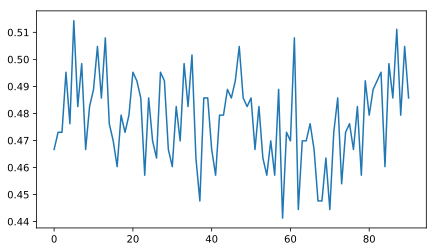

In [54]:
plt.plot(arrayAcuraciaMedia)